In [4]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb

#### Hyper Param Setting

In [5]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'resnet152',
    'img_size': 260,
    'epochs': 200,
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'label_encoder':False,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 12,
    'model_path': './models'
}

#### wandb init

In [6]:
category = 'temp'
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M")
project_name = 'KD_'+ CFG['model'] + '_' + category
user = 'hojunking'
run_name = project_name + '_' + run_id

In [8]:
# TRAIN DATASET DATAFRAME
train_path = '../Data/carbon_reduction_data/train/'
label_list = ["10Kwalk","battery",'box','else','toothcup', 'tumbler','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'green dish','leftover','wrap']

train_img_paths = []
train_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []

    dir_path = train_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    train_img_paths.extend(img_paths)
    train_img_labels.extend(img_labels)

print('Train_Images: ',len(train_img_paths))
print("Train_Images_labels:", len(train_img_labels))

label: 10Kwalk 1467
label: battery 2103
label: box 5907
label: else 2838
label: toothcup 2105
label: tumbler 2508
label: handkerchief 1824
label: milk 1781
label: paper 1249
label: pet 5199
label: plug 2198
label: receipt 632
label: shopping bag 1284
label: stairs 3045
label: transportation 1677
label: trash picking 1221
label: green dish 1261
label: leftover 1483
label: wrap 1266
Train_Images:  41048
Train_Images_labels: 41048


In [9]:
# TEST DATASET DATAFRAME
test_path = '../Data/carbon_reduction_data/test/'
test_img_paths = []
test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []
    dir_path = test_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    test_img_paths.extend(img_paths)
    test_img_labels.extend(img_labels)

print('Test_Images: ',len(test_img_paths))
print("Test_Images_labels:", len(test_img_labels))

label: 10Kwalk 489
label: battery 702
label: box 1969
label: else 946
label: toothcup 702
label: tumbler 837
label: handkerchief 609
label: milk 594
label: paper 417
label: pet 1734
label: plug 733
label: receipt 211
label: shopping bag 429
label: stairs 1016
label: transportation 559
label: trash picking 407
label: green dish 421
label: leftover 495
label: wrap 423
Test_Images:  13693
Test_Images_labels: 13693


In [6]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = train_img_labels
train = trn_df
train

,image_id,dir,label
0,0720.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,unlabeled
1,0282.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,unlabeled
2,1028.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,unlabeled
3,1322.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,unlabeled
4,0540.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,unlabeled
...,...,...,...
5194,2893.jpg,../Data/carbon_reduction_data/bin/train/labeled,labeled
5195,1059.jpg,../Data/carbon_reduction_data/bin/train/labeled,labeled
5196,1512.jpg,../Data/carbon_reduction_data/bin/train/labeled,labeled
5197,2070.jpg,../Data/carbon_reduction_data/bin/train/labeled,labeled


In [7]:
## Pandas 데이터프레임 만들기
tst_df = pd.DataFrame(test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = test_img_labels
test = tst_df
test

,image_id,dir,label
0,0282.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled
1,0540.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled
2,0466.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled
3,0190.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled
4,0234.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled
...,...,...,...
1729,0011.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled
1730,0868.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled
1731,0611.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled
1732,0692.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled


##### Label Encoding

In [8]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)
test['label'] = le.transform(test['label'].values)
train

,image_id,dir,label
0,0720.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,1
1,0282.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,1
2,1028.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,1
3,1322.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,1
4,0540.jpg,../Data/carbon_reduction_data/bin/train/unlabeled,1
...,...,...,...
5194,2893.jpg,../Data/carbon_reduction_data/bin/train/labeled,0
5195,1059.jpg,../Data/carbon_reduction_data/bin/train/labeled,0
5196,1512.jpg,../Data/carbon_reduction_data/bin/train/labeled,0
5197,2070.jpg,../Data/carbon_reduction_data/bin/train/labeled,0


In [9]:
def label_encoding_classes():
    # define certain classes to transform differently
    capture_image_classes = ['10Kwalk', 'battery','receipt']
    return le.transform(capture_image_classes)

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [11]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [12]:
transform_train = A.Compose([
    A.OneOf([
        A.Compose([
            A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
        ], p=0.8),
        A.Compose([
            A.Resize(p=1, height = CFG['img_size'], width = CFG['img_size']),
        ], p=0.2),
    ], p=1.0),
    A.HorizontalFlip(p=0.5),
    A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
    A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose([
    A.OneOf([
        A.Compose([
            A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
        ], p=0.6),
        A.Compose([
            A.Resize(p=1, height = CFG['img_size'], width = CFG['img_size']),
        ], p=0.4),
    ], p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
])

transform_test = A.Compose([
    A.Resize(height = CFG['img_size'], width = CFG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True, encoded_class=False):
        super(CustomDataset,self).__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
         
        if encoded_class == True:
            self.encoded_class = label_encoding_classes()
        else:
            self.encoded_class = encoded_class
            
        if output_label == True:
            self.labels = self.df['label'].values
        
    # AUGMENTATION DIFFERENTLY DEPENDING ON THE TARGET
    def custom_augmentation(self, img, target):
        if self.encoded_class is not False and target in self.encoded_class:
            return self.transform2(image=img)
        else:
            return self.transform(image=img)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # GET LABELS
        if self.output_label:
            target = self.labels[index]
            
            # CUSTOM AUGMENTATION
            transformed = self.custom_augmentation(img, target) 
            img = transformed['image']
            return img, target
        else:
            transformed =self.transform(image=img)
            img = transformed['image']
            return img

In [14]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch_str, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        model_arch = getattr(models, model_arch_str)
        self.backbone = model_arch(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [15]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = CustomDataset(train_, train_data_root, transform=transform_train,
                            transform2=transform_train_cap, output_label=True, encoded_class=CFG['label_encoder'])
    valid_ds = CustomDataset(valid_, valid_data_root, transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,
        sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [16]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    t = time.time()
    
    # SET MODEL TRAINING MODE
    model.train()
    
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        # TEACHER MODEL PREDICTION
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    t = time.time()
    
    # SET MODEL VALID MODE
    model.eval()
    
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        # TEACHER MODEL PREDICTION
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        # TQDM
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [17]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}'.format(run_name)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    # TEST PROCESS FOLD BREAK
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        model =Teacher(CFG['model'], train.label.nunique(), pretrained=True)
        
        # MODEL FREEZING
        #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        if CFG['freezing'] ==True:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print(f"{name}: {param.requires_grad}")

        model.to(device)
        # MODEL DATA PARALLEL
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        

        start = time.time()
        print(f'Fold: {fold}')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
            
            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                best_epoch = epoch
                # SAVE WITH DATAPARARELLEL WRAPPER
                #torch.save(model.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))
                # SAVE WITHOUT DATAPARARELLEL WRAPPER
                torch.save(model.module.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        # K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: resnet152
Training start with fold: 0 epoch: 200 

cls_cnts: 2
num_samples:4159


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 0
Epoch 0/199


epoch 0 loss: 0.0149: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:22<00:00,  1.32s/it]


Epoch [0], Train Loss : [0.07135] Val Loss : [0.01455] Val F1 Score : [0.99682]
 present score: 0.9968199316896865
Epoch 1/199


epoch 1 loss: 0.0174: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.16s/it]

Epoch [1], Train Loss : [0.02798] Val Loss : [0.01669] Val F1 Score : [0.99364]
 present score: 0.9936357442711499
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9968199316896865
Epoch 2/199



epoch 2 loss: 0.0137: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.09s/it]

Epoch [2], Train Loss : [0.02566] Val Loss : [0.01313] Val F1 Score : [0.99576]
 present score: 0.9957571628474333
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9968199316896865
Epoch 3/199



epoch 3 loss: 0.0183: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]

Epoch [3], Train Loss : [0.00764] Val Loss : [0.01755] Val F1 Score : [0.99365]
 present score: 0.9936521112833723
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9968199316896865
Epoch 4/199



epoch 4 loss: 0.0243: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.12s/it]

Epoch [4], Train Loss : [0.01341] Val Loss : [0.02327] Val F1 Score : [0.99260]
 present score: 0.9925988505852297
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9968199316896865
Epoch 5/199



epoch 5 loss: 0.0103: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:20<00:00,  1.22s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [5], Train Loss : [0.00520] Val Loss : [0.00996] Val F1 Score : [0.99682]
 present score: 0.9968199316896865
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9968199316896865
stop called
time : 0:08:25
fold: 0, Best Epoch : 0/ 6
Best Train Marco F1 : 0.97860
[[2038   43]
 [  46 2032]]
Best Valid Marco F1 : 0.99682
[[677   2]
 [  1 360]]
-----------------------------------------------------------------------
Training start with fold: 1 epoch: 200 

cls_cnts: 2
num_samples:4159
Fold: 1
Epoch 0/199


epoch 0 loss: 0.0105: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:16<00:00,  1.04it/s]

Epoch [0], Train Loss : [0.08417] Val Loss : [0.01003] Val F1 Score : [0.99471]
 present score: 0.9947134647037355
Epoch 1/199



epoch 1 loss: 0.0124: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.10s/it]

Epoch [1], Train Loss : [0.02077] Val Loss : [0.01190] Val F1 Score : [0.99366]
 present score: 0.9936601859678783
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9947134647037355
Epoch 2/199



epoch 2 loss: 0.0136: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:17<00:00,  1.02s/it]

Epoch [2], Train Loss : [0.02309] Val Loss : [0.01297] Val F1 Score : [0.99577]
 present score: 0.9957680741889148
Epoch 3/199



epoch 3 loss: 0.0080: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.13s/it]

Epoch [3], Train Loss : [0.01981] Val Loss : [0.00763] Val F1 Score : [0.99576]
 present score: 0.9957626428070862
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9957680741889148
Epoch 4/199



epoch 4 loss: 0.0100: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:16<00:00,  1.02it/s]

Epoch [4], Train Loss : [0.01326] Val Loss : [0.00961] Val F1 Score : [0.99576]
 present score: 0.9957626428070862
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9957680741889148
Epoch 5/199



epoch 5 loss: 0.0050: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.12s/it]


Epoch [5], Train Loss : [0.00966] Val Loss : [0.00480] Val F1 Score : [0.99788]
 present score: 0.9978813214035431
Epoch 6/199


epoch 6 loss: 0.0052: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:16<00:00,  1.01it/s]

Epoch [6], Train Loss : [0.00520] Val Loss : [0.00496] Val F1 Score : [0.99788]
 present score: 0.9978813214035431
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9978813214035431
Epoch 7/199



epoch 7 loss: 0.0018: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:17<00:00,  1.05s/it]


Epoch [7], Train Loss : [0.00596] Val Loss : [0.00171] Val F1 Score : [0.99894]
 present score: 0.9989399772298955
Epoch 8/199


epoch 8 loss: 0.0027: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.12s/it]

Epoch [8], Train Loss : [0.00505] Val Loss : [0.00259] Val F1 Score : [0.99788]
 present score: 0.9978813214035431
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9989399772298955
Epoch 9/199



epoch 9 loss: 0.0011: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.11s/it]


Epoch [9], Train Loss : [0.00382] Val Loss : [0.00106] Val F1 Score : [1.00000]
 present score: 1.0
Epoch 10/199


epoch 10 loss: 0.0010: 100%|███████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.13s/it]

Epoch [10], Train Loss : [0.00189] Val Loss : [0.00100] Val F1 Score : [1.00000]
 present score: 1.0
EarlyStopping counter: 1 out of 5
Best F1 score from now: 1.0
Epoch 11/199



epoch 11 loss: 0.0041: 100%|███████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.12s/it]

Epoch [11], Train Loss : [0.00126] Val Loss : [0.00394] Val F1 Score : [0.99788]
 present score: 0.9978813214035431
EarlyStopping counter: 2 out of 5
Best F1 score from now: 1.0
Epoch 12/199



epoch 12 loss: 0.0017: 100%|███████████████████████████████████████████████████████████████████████| 17/17 [00:20<00:00,  1.18s/it]

Epoch [12], Train Loss : [0.00115] Val Loss : [0.00159] Val F1 Score : [0.99894]
 present score: 0.9989399772298955
EarlyStopping counter: 3 out of 5
Best F1 score from now: 1.0
Epoch 13/199



epoch 13 loss: 0.0026: 100%|███████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.10s/it]

Epoch [13], Train Loss : [0.00086] Val Loss : [0.00251] Val F1 Score : [0.99894]
 present score: 0.9989399772298955
EarlyStopping counter: 4 out of 5
Best F1 score from now: 1.0
Epoch 14/199



epoch 14 loss: 0.0031: 100%|███████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [14], Train Loss : [0.00409] Val Loss : [0.00297] Val F1 Score : [0.99894]
 present score: 0.9989399772298955
EarlyStopping counter: 5 out of 5
Best F1 score from now: 1.0
stop called
time : 0:20:06
fold: 1, Best Epoch : 9/ 15
Best Train Marco F1 : 0.99856
[[2110    3]
 [   3 2043]]
Best Valid Marco F1 : 1.00000
[[679   0]
 [  0 361]]
-----------------------------------------------------------------------
Training start with fold: 2 epoch: 200 

cls_cnts: 2
num_samples:4159
Fold: 2
Epoch 0/199


epoch 0 loss: 0.0396: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:21<00:00,  1.25s/it]

Epoch [0], Train Loss : [0.07195] Val Loss : [0.03790] Val F1 Score : [0.99047]
 present score: 0.9904720702379437
Epoch 1/199



epoch 1 loss: 0.0180: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.08s/it]

Epoch [1], Train Loss : [0.02743] Val Loss : [0.01717] Val F1 Score : [0.99682]
 present score: 0.9968158034126016
Epoch 2/199



epoch 2 loss: 0.0234: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]

Epoch [2], Train Loss : [0.01371] Val Loss : [0.02235] Val F1 Score : [0.99788]
 present score: 0.9978813214035431
Epoch 3/199



epoch 3 loss: 0.0250: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.08s/it]

Epoch [3], Train Loss : [0.01144] Val Loss : [0.02393] Val F1 Score : [0.99894]
 present score: 0.9989399772298955
Epoch 4/199



epoch 4 loss: 0.0602: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:20<00:00,  1.18s/it]

Epoch [4], Train Loss : [0.01605] Val Loss : [0.05761] Val F1 Score : [0.99261]
 present score: 0.9926082290311804
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9989399772298955
Epoch 5/199



epoch 5 loss: 0.0283: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.06s/it]

Epoch [5], Train Loss : [0.00694] Val Loss : [0.02709] Val F1 Score : [0.99682]
 present score: 0.996824023412648
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9989399772298955
Epoch 6/199



epoch 6 loss: 0.0234: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.16s/it]

Epoch [6], Train Loss : [0.00323] Val Loss : [0.02237] Val F1 Score : [0.99788]
 present score: 0.9978785814237167
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9989399772298955
Epoch 7/199



epoch 7 loss: 0.0308: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.11s/it]

Epoch [7], Train Loss : [0.00184] Val Loss : [0.02946] Val F1 Score : [0.99894]
 present score: 0.9989399772298955
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9989399772298955
Epoch 8/199



epoch 8 loss: 0.0249: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [8], Train Loss : [0.00055] Val Loss : [0.02380] Val F1 Score : [0.99894]
 present score: 0.9989399772298955
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9989399772298955
stop called
time : 0:12:06
fold: 2, Best Epoch : 3/ 9
Best Train Marco F1 : 0.99615
[[2087    8]
 [   8 2056]]
Best Valid Marco F1 : 0.99894
[[678   1]
 [  0 361]]
-----------------------------------------------------------------------
Training start with fold: 3 epoch: 200 

cls_cnts: 2
num_samples:4159
Fold: 3
Epoch 0/199


epoch 0 loss: 0.0173: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]

Epoch [0], Train Loss : [0.07659] Val Loss : [0.01695] Val F1 Score : [0.99254]
 present score: 0.9925407925407925
Epoch 1/199



epoch 1 loss: 0.0066: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.11s/it]

Epoch [1], Train Loss : [0.03016] Val Loss : [0.00868] Val F1 Score : [0.99469]
 present score: 0.994693005687669
Epoch 2/199



epoch 2 loss: 0.0120: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]

Epoch [2], Train Loss : [0.01660] Val Loss : [0.01152] Val F1 Score : [0.99361]
 present score: 0.9936106423761858
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.994693005687669
Epoch 3/199



epoch 3 loss: 0.0123: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.10s/it]

Epoch [3], Train Loss : [0.01897] Val Loss : [0.01348] Val F1 Score : [0.99681]
 present score: 0.9968116383375965
Epoch 4/199



epoch 4 loss: 0.0043: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.14s/it]

Epoch [4], Train Loss : [0.01587] Val Loss : [0.00448] Val F1 Score : [0.99788]
 present score: 0.9978758169934641
Epoch 5/199



epoch 5 loss: 0.0046: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.13s/it]

Epoch [5], Train Loss : [0.00989] Val Loss : [0.00454] Val F1 Score : [0.99788]
 present score: 0.9978758169934641
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9978758169934641
Epoch 6/199



epoch 6 loss: 0.0023: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.09s/it]

Epoch [6], Train Loss : [0.00434] Val Loss : [0.00232] Val F1 Score : [0.99894]
 present score: 0.9989372127791988
Epoch 7/199



epoch 7 loss: 0.0041: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.09s/it]

Epoch [7], Train Loss : [0.00255] Val Loss : [0.00407] Val F1 Score : [0.99894]
 present score: 0.9989372127791988
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9989372127791988
Epoch 8/199



epoch 8 loss: 0.0022:  32%|███████████████████████▎                                                | 21/65 [00:25<00:38,  1.15it/s]

In [18]:
test

,image_id,dir,label
0,0282.jpg,../Data/carbon_reduction_data/test/toothcup,0
1,0540.jpg,../Data/carbon_reduction_data/test/toothcup,0
2,0466.jpg,../Data/carbon_reduction_data/test/toothcup,0
3,0190.jpg,../Data/carbon_reduction_data/test/toothcup,0
4,0234.jpg,../Data/carbon_reduction_data/test/toothcup,0
...,...,...,...
1534,0074.jpg,../Data/carbon_reduction_data/test/tumbler,1
1535,0515.jpg,../Data/carbon_reduction_data/test/tumbler,1
1536,0011.jpg,../Data/carbon_reduction_data/test/tumbler,1
1537,0611.jpg,../Data/carbon_reduction_data/test/tumbler,1


In [18]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [19]:
# RUN INFERENCE
model = Teacher(CFG['model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/KD_resnet152_pet_202305202118/' + CFG['model'] + '.pth'
test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

# INFERENCE VIA MULTI-GPU
# if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
test

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:29<00:00,  1.07s/it]


,image_id,dir,label,pred
0,0282.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,1,1
1,0540.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,1,1
2,0466.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,1,1
3,0190.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,1,1
4,0234.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,1,1
...,...,...,...,...
1729,0011.jpg,../Data/carbon_reduction_data/bin/test/labeled,0,0
1730,0868.jpg,../Data/carbon_reduction_data/bin/test/labeled,0,0
1731,0611.jpg,../Data/carbon_reduction_data/bin/test/labeled,0,0
1732,0692.jpg,../Data/carbon_reduction_data/bin/test/labeled,0,0


In [20]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,0282.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled,unlabeled
1,0540.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled,unlabeled
2,0466.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled,unlabeled
3,0190.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled,unlabeled
4,0234.jpg,../Data/carbon_reduction_data/bin/test/unlabeled,unlabeled,unlabeled
...,...,...,...,...
1729,0011.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled,labeled
1730,0868.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled,labeled
1731,0611.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled,labeled
1732,0692.jpg,../Data/carbon_reduction_data/bin/test/labeled,labeled,labeled


accuracy: 0.9988
f1_score: 0.9987


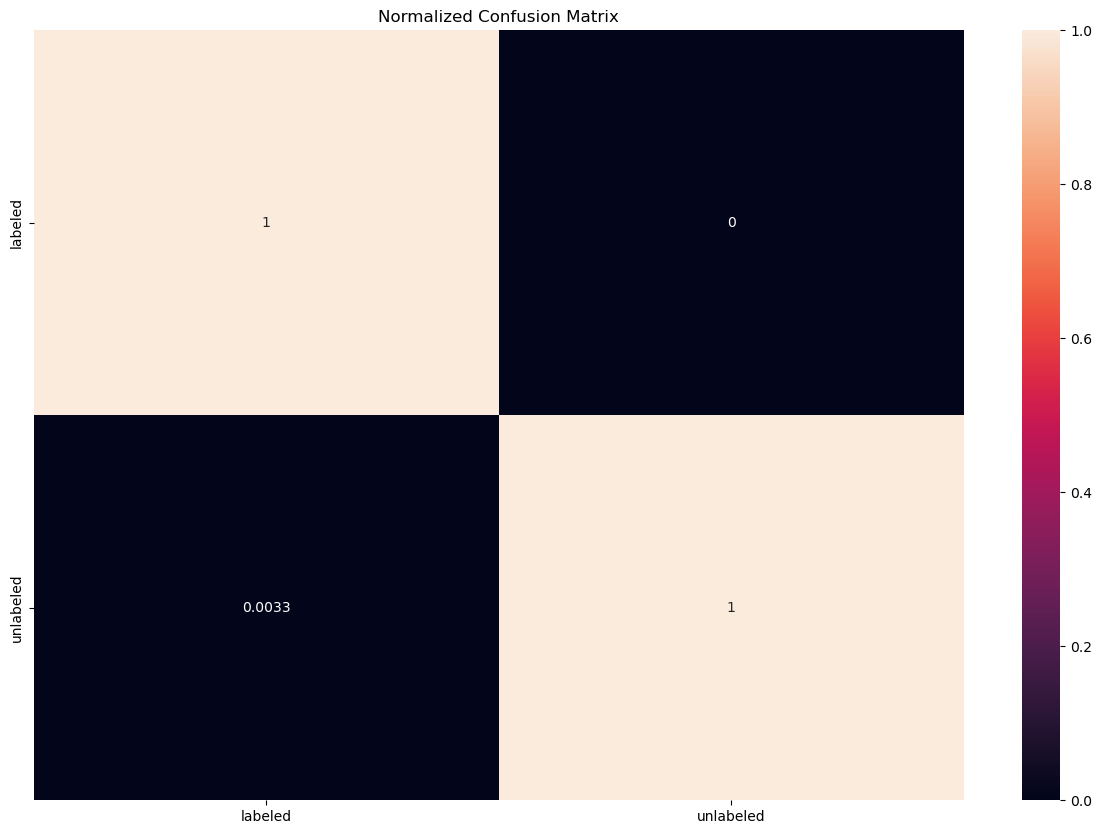

In [21]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [23]:
test.to_csv('test_result/incep_res_0403.csv', index=False)

In [22]:
import json
import jsonlines
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import random

In [23]:
test['pred'].value_counts()

bottle            1229
dishes            1163
stairs             806
else               597
plug               593
battery            501
transportation     458
handkerchief       443
10Kwalk            411
pet                410
shopping bag       409
box                382
paper              374
milk               371
trash picking      325
receipt            288
Name: pred, dtype: int64

In [24]:
tmp_list = []
label = test[test.pred == 'else']

label.sort_values(by=['image_id'],ascending=True, inplace=True)
label.reset_index(inplace=True, drop=True)
tmp = label['image_id'].value_counts().index.sort_values()
label

/tmp/ipykernel_1475945/30508609.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.sort_values(by=['image_id'],ascending=True, inplace=True)


,image_id,dir,label,pred
0,10Kwalk_1047.jpg,../Data/carbon_data/10Kwalk,10Kwalk,else
1,10Kwalk_1174.jpg,../Data/carbon_data/10Kwalk,10Kwalk,else
2,16583193231991658319380893.jpg,../Data/carbon_data/else/instance_spoon,else,else
3,16583311864571658331260534.jpg,../Data/carbon_data/else/instance_spoon,else,else
4,20220722_125118_HDR1658461897787.jpg,../Data/carbon_data/else/instance_spoon,else,else
...,...,...,...,...
592,wrap_990.jpg,../Data/carbon_data/dishes/wrap,dishes,else
593,wrap_995.jpg,../Data/carbon_data/dishes/wrap,dishes,else
594,양치컵 사용_063.jpg,../Data/carbon_data/bottle/toothcup/toothcup_852,bottle,else
595,양치컵 사용_140.jpg,../Data/carbon_data/bottle/toothcup/toothcup_852,bottle,else


In [ ]:
## show img status

back = 0
plt.figure(figsize=(16,500))
for i in range(len(label[200:400])):
    plt.subplot(100,4,i+1)
    if i % 4 == 0:
        plt.title(f"{(i+1+back)/4}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    path = label['dir'][i] + '/' + label['image_id'][i]
    try:
    # im_bgr = cv2.imread(path)
    # im_rgb = im_bgr[:, :, ::-1]
        temp = Image.open(path).convert("RGB")
        image = np.array(temp).copy()
        temp.close()

        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(label['image_id'][i], loc='left', fontsize=10)
    except:
        plt.xlabel(path, loc='left', fontsize=10)
        
plt.show()